In [13]:
import chromadb

client = chromadb.PersistentClient(path="./chromadb_data")

collection = client.get_or_create_collection(name="ressources")

In [14]:
import os
from langchain_text_splitters import MarkdownTextSplitter
output_dir = "output_2"
splitter = MarkdownTextSplitter()

for zeendoc_folder in os.listdir(output_dir):
    zeendoc_path = os.path.join(output_dir, zeendoc_folder)
    if os.path.isdir(zeendoc_path):
        for md_file in os.listdir(zeendoc_path):
            if md_file.endswith(".md"):
                md_path = os.path.join(zeendoc_path, md_file)
                with open(md_path, "r", encoding="utf-8") as f:
                    md_content = f.read()
                    # split the content
                    chunks = splitter.split_text(md_content)
                    for i, chunk in enumerate(chunks):
                        metadata = {
                            "zeendoc": zeendoc_folder,
                            "page": md_file,
                            "chunk_index": i
                        }
                        # print le text 
                        print(f"index : {i}, \n  chunk {chunk}")
                        collection.add(
                            documents=[chunk],
                            metadatas=[metadata],
                            ids=[f"{zeendoc_folder}_{md_file}_chunk_{i}"]
                        )

index : 0, 
  chunk ---
source_file: 23248.pdf
page_number: 1
total_pages: 8
total_images: 1
document_title: Rapport d'Activité
language: fr
document_type: rapport
summary: Le rapport d'activité de l'ORSTOM (Institut Français de Recherche Scientifique
  pour le Développement en Coopération) pour l'année 1985 décrit les efforts de renouvellement
  et de modernisation de l'institut. Il met en lumière les progrès réalisés dans divers
  départements de recherche, notamment en climatologie, en santé, et en développement.
  Le rapport souligne également les défis et les succès dans la coopération internationale,
  notamment en Afrique, en Asie, et en Amérique latine. Les activités de recherche
  sont centrées sur des thèmes tels que les changements climatiques, la sécurité alimentaire,
  et les ressources naturelles. Le rapport inclut également des informations sur les
  moyens financiers et humains de l'institut.
key_points:
- Efforts de renouvellement et de modernisation de l'ORSTOM en 198

C:\Users\thoma\.cache\chroma\onnx_models\all-MiniLM-L6-v2\onnx.tar.gz: 100%|██████████| 79.3M/79.3M [02:48<00:00, 493kiB/s]   


index : 0, 
  chunk ---
source_file: 23248.pdf
page_number: 2
total_pages: 8
total_images: 0
document_title: Rapport d'Activité
language: fr
document_type: rapport
---

4
Une Recherche Fondamentale pour l'Action :
Connaissances Climatiques et Développement

11
Les Départements,
Opérateurs de la Recherche

12
Département A :
Climat, Tectonique, Surface

19
Département B :
Evaluation et Contrôle des Repercussions
Induites par les Politiques de Développement

25
Département C :
Necessite d'une Démarche Intégrée

33
Département D :
Confirmation des Options
et Nouvelles Orientations

38
Département E :
Les Conditions de la Sécurité Alimentaire

43
Département F :
Energies, Eau, Matières Premières

47
Département G :
Pour l'Amélioration de la Santé,
Recherches Fomfamentales,
Nouveaux Outils Méthodologiques,
Stratégies de Prévention et de Contrôle

55
Département H :
Quelques Questions Ciels
Relatives an Développement

60
Annexe :
Grands Programmes et Départements

63
DIVA :
Des Outils et des

In [16]:
# retrouve les chunks d'un zeendoc avec metadata (inclure les embeddings)
results = collection.get(
    where={"zeendoc": "23248.Zeendoc"},
    include=["embeddings", "documents", "metadatas"]
)
print(f"Nombre de chunks: {len(results['ids'])}")
print(f"Embeddings disponibles: {results['embeddings'] is not None}")

Nombre de chunks: 11
Embeddings disponibles: True


## 🎯 K-Means Clustering pour Réduction de Contexte

On utilise K-means sur les embeddings pour regrouper les chunks similaires et ne garder que les clusters les plus représentatifs.

In [17]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Récupérer tous les chunks avec leurs embeddings
all_results = collection.get(
    include=["embeddings", "documents", "metadatas"]
)

embeddings = np.array(all_results['embeddings'])
documents = all_results['documents']
metadatas = all_results['metadatas']
ids = all_results['ids']

print(f"📊 Total de chunks: {len(documents)}")
print(f"📐 Dimension des embeddings: {embeddings.shape}")

📊 Total de chunks: 218
📐 Dimension des embeddings: (218, 384)


C:\Users\thoma\AppData\Local\Temp\ipykernel_6168\3146219304.py:29: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thoma\AppData\Local\Temp\ipykernel_6168\3146219304.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


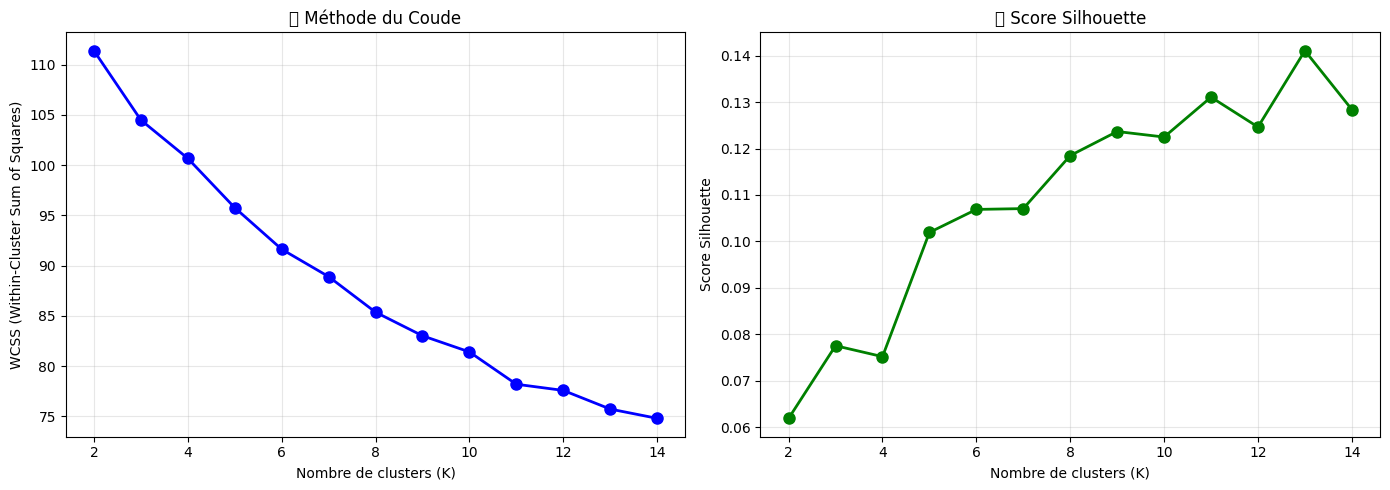


✅ Nombre optimal de clusters suggéré: 13


In [18]:
# Méthode du coude (Elbow Method) pour trouver le nombre optimal de clusters
wcss = []
silhouette_scores = []
K_range = range(2, min(15, len(documents)))

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(K_range, wcss, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de clusters (K)')
axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)')
axes[0].set_title('🔍 Méthode du Coude')
axes[0].grid(True, alpha=0.3)

# Silhouette score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Nombre de clusters (K)')
axes[1].set_ylabel('Score Silhouette')
axes[1].set_title('📈 Score Silhouette')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Trouver le meilleur K basé sur le silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Nombre optimal de clusters suggéré: {optimal_k}")

In [19]:
# Appliquer K-Means avec le nombre optimal de clusters
N_CLUSTERS = optimal_k  # Ou ajuster manuellement si besoin

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Organiser les chunks par cluster
clusters = {}
for idx, label in enumerate(cluster_labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append({
        'id': ids[idx],
        'document': documents[idx],
        'metadata': metadatas[idx],
        'embedding': embeddings[idx]
    })

# Afficher la distribution des clusters
print("📊 Distribution des chunks par cluster:")
for cluster_id, items in sorted(clusters.items()):
    print(f"  Cluster {cluster_id}: {len(items)} chunks")

📊 Distribution des chunks par cluster:
  Cluster 0: 14 chunks
  Cluster 1: 15 chunks
  Cluster 2: 16 chunks
  Cluster 3: 18 chunks
  Cluster 4: 25 chunks
  Cluster 5: 15 chunks
  Cluster 6: 16 chunks
  Cluster 7: 33 chunks
  Cluster 8: 16 chunks
  Cluster 9: 14 chunks
  Cluster 10: 16 chunks
  Cluster 11: 18 chunks
  Cluster 12: 2 chunks


In [23]:
# Sélectionner les chunks les plus représentatifs de chaque cluster
# (les plus proches du centroïde)

def get_representative_chunks(clusters, kmeans, n_per_cluster=2):
    """
    Sélectionne les n chunks les plus proches du centroïde pour chaque cluster.
    """
    representative_chunks = []
    
    for cluster_id, items in clusters.items():
        centroid = kmeans.cluster_centers_[cluster_id]
        
        # Calculer la distance de chaque chunk au centroïde
        distances = []
        for item in items:
            dist = np.linalg.norm(item['embedding'] - centroid)
            distances.append((dist, item))
        
        # Trier par distance et prendre les n plus proches
        distances.sort(key=lambda x: x[0])
        for dist, item in distances[:n_per_cluster]:
            representative_chunks.append({
                'cluster_id': cluster_id,
                'distance_to_centroid': dist,
                **item
            })
    
    return representative_chunks

# Obtenir les chunks représentatifs
representative_chunks = get_representative_chunks(clusters, kmeans, n_per_cluster=2)
print(f"🎯 Chunks représentatifs sélectionnés: {len(representative_chunks)} / {len(documents)}")
print(f"📉 Réduction du contexte: {100 * (1 - len(representative_chunks)/len(documents)):.1f}%")

🎯 Chunks représentatifs sélectionnés: 26 / 218
📉 Réduction du contexte: 88.1%


## 📊 Calcul de la Représentativité Sémantique

On mesure combien d'information sémantique les chunks sélectionnés représentent par rapport à l'ensemble total.

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_semantic_coverage(representative_chunks, all_embeddings, threshold=0.7):
    """
    Calcule le pourcentage de l'information sémantique couverte par les chunks sélectionnés.
    
    Métriques:
    1. Coverage: % de chunks originaux ayant un chunk représentatif similaire (cosine > threshold)
    2. Average Max Similarity: Similarité moyenne maximale pour chaque chunk original
    3. Variance Explained: Basé sur la distance aux centroïdes
    """
    selected_embeddings = np.array([chunk['embedding'] for chunk in representative_chunks])
    
    # Calculer la matrice de similarité cosinus
    similarity_matrix = cosine_similarity(all_embeddings, selected_embeddings)
    
    # Pour chaque chunk original, trouver la similarité max avec un chunk représentatif
    max_similarities = similarity_matrix.max(axis=1)
    
    # Métriques de couverture
    coverage_count = np.sum(max_similarities >= threshold)
    coverage_percentage = 100 * coverage_count / len(all_embeddings)
    avg_max_similarity = np.mean(max_similarities)
    
    # Variance expliquée (basée sur la réduction de variance)
    total_variance = np.var(all_embeddings, axis=0).sum()
    selected_variance = np.var(selected_embeddings, axis=0).sum()
    variance_ratio = selected_variance / total_variance
    
    return {
        'coverage_percentage': coverage_percentage,
        'avg_max_similarity': avg_max_similarity,
        'variance_ratio': variance_ratio,
        'max_similarities': max_similarities,
        'threshold': threshold
    }

# Calculer la couverture sémantique
semantic_metrics = calculate_semantic_coverage(representative_chunks, embeddings, threshold=0.7)

print("=" * 60)
print("📈 MÉTRIQUES DE REPRÉSENTATIVITÉ SÉMANTIQUE")
print("=" * 60)
print(f"\n🎯 Couverture (seuil={semantic_metrics['threshold']}):")
print(f"   {semantic_metrics['coverage_percentage']:.1f}% des chunks ont un représentant similaire")
print(f"\n📊 Similarité moyenne maximale:")
print(f"   {semantic_metrics['avg_max_similarity']:.3f} (1.0 = parfait)")
print(f"\n📐 Ratio de variance capturée:")
print(f"   {semantic_metrics['variance_ratio']:.3f}")
print(f"\n💡 Efficacité:")
print(f"   {len(representative_chunks)} chunks représentent {semantic_metrics['coverage_percentage']:.1f}% de l'information")
print(f"   Ratio compression: {len(documents)/len(representative_chunks):.1f}x")

📈 MÉTRIQUES DE REPRÉSENTATIVITÉ SÉMANTIQUE

🎯 Couverture (seuil=0.7):
   61.0% des chunks ont un représentant similaire

📊 Similarité moyenne maximale:
   0.741 (1.0 = parfait)

📐 Ratio de variance capturée:
   0.905

💡 Efficacité:
   26 chunks représentent 61.0% de l'information
   Ratio compression: 8.4x


C:\Users\thoma\AppData\Local\Temp\ipykernel_6168\2734160353.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thoma\AppData\Local\Temp\ipykernel_6168\2734160353.py:33: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\thoma\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


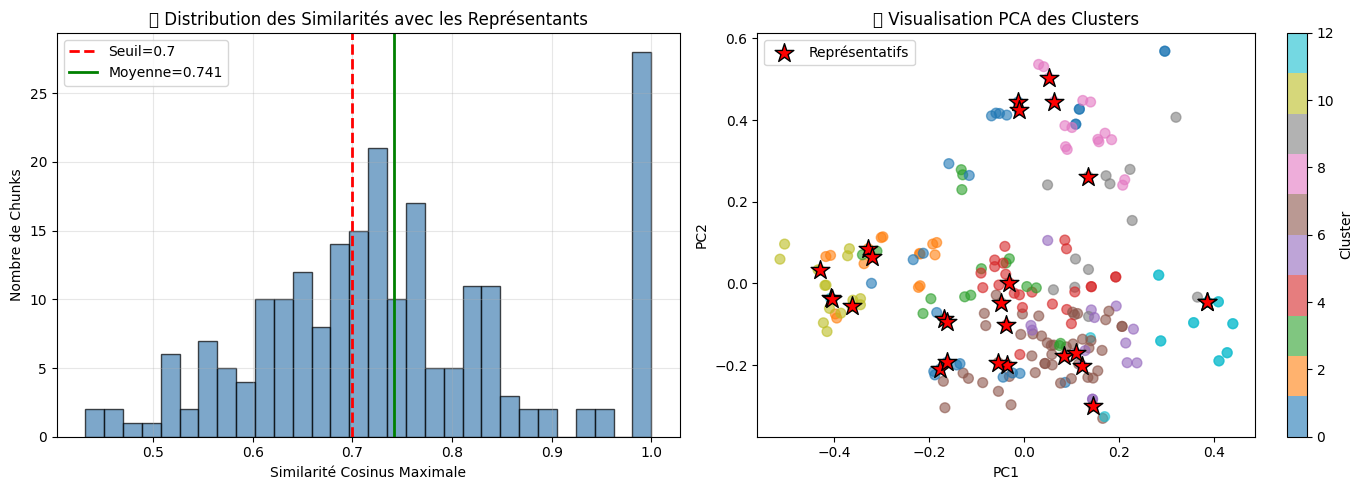

In [25]:
# Visualisation de la distribution des similarités
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme des similarités maximales
axes[0].hist(semantic_metrics['max_similarities'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=semantic_metrics['threshold'], color='red', linestyle='--', linewidth=2, label=f'Seuil={semantic_metrics["threshold"]}')
axes[0].axvline(x=semantic_metrics['avg_max_similarity'], color='green', linestyle='-', linewidth=2, label=f'Moyenne={semantic_metrics["avg_max_similarity"]:.3f}')
axes[0].set_xlabel('Similarité Cosinus Maximale')
axes[0].set_ylabel('Nombre de Chunks')
axes[0].set_title('📊 Distribution des Similarités avec les Représentants')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Visualisation PCA des clusters
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

scatter = axes[1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                          c=cluster_labels, cmap='tab10', alpha=0.6, s=50)

# Marquer les chunks représentatifs
rep_indices = [ids.index(chunk['id']) for chunk in representative_chunks]
axes[1].scatter(embeddings_2d[rep_indices, 0], embeddings_2d[rep_indices, 1], 
                c='red', marker='*', s=200, edgecolors='black', linewidths=1, label='Représentatifs')

axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('🗺️ Visualisation PCA des Clusters')
axes[1].legend()
plt.colorbar(scatter, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

## 🤖 Pydantic AI - Résumé et Carte Mentale

Utilisation de Pydantic AI pour structurer les réponses du LLM et générer un résumé ainsi qu'une carte mentale des documents.

In [26]:
from pydantic import BaseModel, Field
from typing import List
from pydantic_ai import Agent
import os
from dotenv import load_dotenv

load_dotenv()

# ============================================
# MODÈLES PYDANTIC POUR LE RÉSUMÉ
# ============================================

class KeyConcept(BaseModel):
    """Un concept clé extrait du document"""
    name: str = Field(description="Nom du concept")
    description: str = Field(description="Description brève du concept")
    importance: int = Field(description="Importance de 1 à 5", ge=1, le=5)

class DocumentSummary(BaseModel):
    """Résumé structuré d'un document"""
    title: str = Field(description="Titre ou sujet principal du document")
    summary: str = Field(description="Résumé concis en 2-3 phrases")
    key_concepts: List[KeyConcept] = Field(description="Concepts clés identifiés (3-5 concepts)")
    main_themes: List[str] = Field(description="Thèmes principaux abordés (3-5 thèmes)")
    document_type: str = Field(description="Type de document (rapport, procès-verbal, circulaire, etc.)")

# ============================================
# MODÈLES PYDANTIC POUR LA CARTE MENTALE
# ============================================

class MindMapNode(BaseModel):
    """Noeud de la carte mentale"""
    title: str = Field(description="Titre du noeud")
    children: List["MindMapNode"] = Field(default_factory=list, description="Sous-noeuds (2-4 enfants max)")

class MindMap(BaseModel):
    """Carte mentale complète"""
    central_theme: str = Field(description="Thème central de la carte mentale")
    branches: List[MindMapNode] = Field(description="Branches principales de la carte (3-5 branches)")

print("✅ Modèles Pydantic définis")

✅ Modèles Pydantic définis


In [27]:
# Préparer le contexte à partir des chunks représentatifs
def prepare_context_for_analysis(rep_chunks: list) -> str:
    """
    Prépare le contexte textuel à partir des chunks représentatifs.
    """
    context_parts = []
    for chunk in rep_chunks:
        source_info = f"[Source: {chunk['metadata'].get('zeendoc', 'Unknown')} - {chunk['metadata'].get('page', 'Unknown')}]"
        context_parts.append(f"{source_info}\n{chunk['document']}\n")
    
    return "\n---\n".join(context_parts)

# Créer le contexte
analysis_context = prepare_context_for_analysis(representative_chunks)
print(f"📝 Contexte préparé: {len(analysis_context)} caractères")
print(f"📊 Basé sur {len(representative_chunks)} chunks représentatifs")

📝 Contexte préparé: 72575 caractères
📊 Basé sur 26 chunks représentatifs


In [28]:
# ============================================
# AGENT 1: GÉNÉRATION DU RÉSUMÉ
# ============================================

summary_agent = Agent(
    "mistral:mistral-large-latest",
    output_type=DocumentSummary,
    system_prompt="""Tu es un assistant expert en analyse documentaire française.
Tu dois analyser des extraits de documents et produire un résumé structuré.
Identifie le type de document, les thèmes principaux et les concepts clés.
Réponds toujours en français avec précision et concision."""
)

async def generate_summary(context: str, coverage_pct: float, n_chunks: int, total_chunks: int) -> DocumentSummary:
    """Génère un résumé structuré des documents."""
    
    prompt = f"""Analyse les extraits de documents suivants et génère un résumé structuré.

📊 Ces extraits représentent {coverage_pct:.1f}% de l'information sémantique totale
   ({n_chunks} chunks représentatifs sur {total_chunks} au total).

=== EXTRAITS DES DOCUMENTS ===
{context}
=== FIN DES EXTRAITS ===

Génère un résumé complet avec:
- Un titre descriptif
- Un résumé en 2-3 phrases
- Les concepts clés (3-5)
- Les thèmes principaux (3-5)
- Le type de document"""

    result = await summary_agent.run(prompt)
    return result.output

print("✅ Agent de résumé configuré")

✅ Agent de résumé configuré


In [29]:
# ============================================
# AGENT 2: GÉNÉRATION DE LA CARTE MENTALE
# ============================================

mindmap_agent = Agent(
    "mistral:mistral-large-latest",
    output_type=MindMap,
    system_prompt="""Tu es un expert en organisation de l'information et création de cartes mentales.
Tu dois analyser des documents et créer une carte mentale hiérarchique.
Organise l'information de manière logique avec un thème central et des branches.
Chaque branche peut avoir des sous-branches (2-3 niveaux max).
Réponds toujours en français."""
)

async def generate_mindmap(context: str, summary: DocumentSummary) -> MindMap:
    """Génère une carte mentale basée sur le contexte et le résumé."""
    
    # Utiliser le résumé pour enrichir le prompt
    themes_str = ", ".join(summary.main_themes)
    concepts_str = ", ".join([c.name for c in summary.key_concepts])
    
    prompt = f"""Crée une carte mentale hiérarchique basée sur les documents suivants.

📌 Contexte du résumé:
- Titre: {summary.title}
- Type: {summary.document_type}
- Thèmes identifiés: {themes_str}
- Concepts clés: {concepts_str}

=== EXTRAITS DES DOCUMENTS ===
{context}
=== FIN DES EXTRAITS ===

Génère une carte mentale avec:
- Un thème central représentatif
- 3 à 5 branches principales
- Chaque branche peut avoir 2-4 sous-branches
- Maximum 3 niveaux de profondeur"""

    result = await mindmap_agent.run(prompt)
    return result.output

print("✅ Agent de carte mentale configuré")

✅ Agent de carte mentale configuré


In [30]:
# ============================================
# EXÉCUTION: GÉNÉRATION DU RÉSUMÉ
# ============================================

print("🚀 Génération du résumé en cours...")

# Exécuter l'agent de résumé (await direct dans Jupyter)
summary_result = await generate_summary(
    context=analysis_context,
    coverage_pct=semantic_metrics['coverage_percentage'],
    n_chunks=len(representative_chunks),
    total_chunks=len(documents)
)

print("✅ Résumé généré!")
print("\n" + "=" * 70)
print("📄 RÉSUMÉ DU DOCUMENT")
print("=" * 70)
print(f"\n📌 Titre: {summary_result.title}")
print(f"📝 Type: {summary_result.document_type}")
print(f"\n📖 Résumé:\n{summary_result.summary}")

print(f"\n🏷️ Thèmes principaux:")
for theme in summary_result.main_themes:
    print(f"   • {theme}")

print(f"\n💡 Concepts clés:")
for concept in summary_result.key_concepts:
    importance_stars = "⭐" * concept.importance
    print(f"   {importance_stars} {concept.name}")
    print(f"      └─ {concept.description}")

🚀 Génération du résumé en cours...
✅ Résumé généré!

📄 RÉSUMÉ DU DOCUMENT

📌 Titre: Analyse thématique de divers documents administratifs, parlementaires et scientifiques (1975-2003)
📝 Type: Synthèse de rapports, procès-verbaux, circulaires et répertoires numériques

📖 Résumé:
Cette analyse couvre plusieurs types de documents, incluant des rapports budgétaires, des comptes rendus parlementaires, des procès-verbaux de commissions électorales, des rapports d'activité scientifique, et des circulaires fiscales. Les extraits révèlent des enjeux financiers, législatifs, climatiques, et administratifs, ainsi que des questions de conformité et de gestion publique en France et à l'international.

🏷️ Thèmes principaux:
   • Gestion et allocation des ressources budgétaires de l'État
   • Contrôle et régulation des financements politiques et électoraux
   • Recherche scientifique et enjeux climatiques dans les zones tropicales
   • Restructuration et gestion des crises financières dans le secteur 

In [31]:
# ============================================
# EXÉCUTION: GÉNÉRATION DE LA CARTE MENTALE
# ============================================

print("🚀 Génération de la carte mentale en cours...")

# Exécuter l'agent de carte mentale (await direct dans Jupyter)
mindmap_result = await generate_mindmap(
    context=analysis_context,
    summary=summary_result
)

print("✅ Carte mentale générée!")

# Fonction d'affichage récursive
def print_mind_map_node(node: MindMapNode, indent: int = 0):
    """Affiche récursivement un noeud de carte mentale."""
    prefix = "   " * indent
    connector = "├─" if indent > 0 else "🌳"
    print(f"{prefix}{connector} {node.title}")
    for child in node.children:
        print_mind_map_node(child, indent + 1)

print("\n" + "=" * 70)
print("🗺️ CARTE MENTALE")
print("=" * 70)
print(f"\n🎯 Thème Central: {mindmap_result.central_theme}\n")

for branch in mindmap_result.branches:
    print_mind_map_node(branch)
    print()

🚀 Génération de la carte mentale en cours...
✅ Carte mentale générée!

🗺️ CARTE MENTALE

🎯 Thème Central: Analyse thématique des documents administratifs, parlementaires et scientifiques (1975-2003)

🌳 Gestion et allocation des ressources budgétaires de l'État
   ├─ Modifications budgétaires et allocations de crédits
      ├─ Dépenses ordinaires des services civils
         ├─ Justice (réforme de la procédure d'instruction, création d'emplois)
         ├─ Agriculture (amélioration du cadre de vie, bourses scolaires)
         ├─ Éducation nationale (médecine scolaire, subventions aux institutions culturelles)
      ├─ Services financiers (informatisation, abondement des crédits)
   ├─ Contrôle parlementaire et suivi des dépenses
      ├─ Rôle du Parlement dans le suivi des restructurations financières
      ├─ Présentation annuelle des rapports d'activités
   ├─ Exemples de modifications budgétaires (en millions de francs)
      ├─ Justice : +8,97
      ├─ Agriculture : +7,4
      ├─ Éc

In [32]:
# ============================================
# EXPORT: CARTE MENTALE EN MERMAID
# ============================================

def generate_mermaid_mindmap(mind_map: MindMap) -> str:
    """Génère le code Mermaid pour la carte mentale."""
    lines = ["mindmap", f"  root(({mind_map.central_theme}))"]
    
    def add_node(node: MindMapNode, level: int = 2):
        indent = "  " * level
        # Échapper les caractères spéciaux
        title = node.title.replace("(", "[").replace(")", "]")
        lines.append(f"{indent}{title}")
        for child in node.children:
            add_node(child, level + 1)
    
    for branch in mind_map.branches:
        add_node(branch)
    
    return "\n".join(lines)

mermaid_code = generate_mermaid_mindmap(mindmap_result)
print("📊 Code Mermaid pour la carte mentale:\n")
print("```mermaid")
print(mermaid_code)
print("```")

# Sauvegarder dans un fichier
with open("mind_map.md", "w", encoding="utf-8") as f:
    f.write("# Carte Mentale des Documents\n\n")
    f.write("```mermaid\n")
    f.write(mermaid_code)
    f.write("\n```\n")
    
print("\n✅ Carte mentale sauvegardée dans 'mind_map.md'")

📊 Code Mermaid pour la carte mentale:

```mermaid
mindmap
  root((Analyse thématique des documents administratifs, parlementaires et scientifiques (1975-2003)))
    Gestion et allocation des ressources budgétaires de l'État
      Modifications budgétaires et allocations de crédits
        Dépenses ordinaires des services civils
          Justice [réforme de la procédure d'instruction, création d'emplois]
          Agriculture [amélioration du cadre de vie, bourses scolaires]
          Éducation nationale [médecine scolaire, subventions aux institutions culturelles]
        Services financiers [informatisation, abondement des crédits]
      Contrôle parlementaire et suivi des dépenses
        Rôle du Parlement dans le suivi des restructurations financières
        Présentation annuelle des rapports d'activités
      Exemples de modifications budgétaires [en millions de francs]
        Justice : +8,97
        Agriculture : +7,4
        Économie et finances : +10
    Contrôle et régulatio

In [33]:
# ============================================
# EXPORT: RÉSULTATS COMPLETS EN JSON
# ============================================
import json

# Convertir en dict pour l'export
analysis_export = {
    "metadata": {
        "total_chunks": len(documents),
        "representative_chunks": len(representative_chunks),
        "n_clusters": N_CLUSTERS,
        "semantic_coverage": semantic_metrics['coverage_percentage'],
        "avg_similarity": semantic_metrics['avg_max_similarity']
    },
    "summary": summary_result.model_dump(),
    "mind_map": mindmap_result.model_dump()
}

with open("analysis_result.json", "w", encoding="utf-8") as f:
    json.dump(analysis_export, f, ensure_ascii=False, indent=2)

print("💾 Analyse exportée dans 'analysis_result.json'")
print(f"\n📈 Statistiques finales:")
print(f"   • Chunks totaux: {len(documents)}")
print(f"   • Chunks représentatifs: {len(representative_chunks)}")
print(f"   • Réduction: {100*(1-len(representative_chunks)/len(documents)):.1f}%")
print(f"   • Couverture sémantique: {semantic_metrics['coverage_percentage']:.1f}%")
print(f"\n📄 Résumé: {summary_result.title}")
print(f"🗺️ Carte mentale: {mindmap_result.central_theme}")

💾 Analyse exportée dans 'analysis_result.json'

📈 Statistiques finales:
   • Chunks totaux: 218
   • Chunks représentatifs: 26
   • Réduction: 88.1%
   • Couverture sémantique: 61.0%

📄 Résumé: Analyse thématique de divers documents administratifs, parlementaires et scientifiques (1975-2003)
🗺️ Carte mentale: Analyse thématique des documents administratifs, parlementaires et scientifiques (1975-2003)
